# Кластеризация данных
КБ-211 Коренев Денис

**Задание:** разбить заданный датасет на 5 кластеров и на 2 кластера, используя агломеративный иерархический метод и метод к-средних; сравнить результаты; данные выбрать из папки "данные" в соответствии с алфавитом названий файлов и с номером по списку в группе. Можно использовать функции библиотек Пайтона с готовыми методами кластеризации. Обязательно нужно оценить качество классификации (с помощью двух функционалов из дополнительных материалов ИТМО, смотреть только внутренние оценки) , дать интерпретацию для полученных кластеров (в случае 2 кластеров, но это не оценка качества, это другое) и сделать общий вывод по работе. Интерпретация интересна двух типов. 
Первая: 
1) выбрать признак, который можно считать разметкой на классы 
2) не учитывать его при кластеризации 
3) оценить сколько элементов каждого класса попало в тот или иной кластер. 

Вторая: качественно посмотреть на значения признаков в первом и втором кластере (например, в первом кластере значения такого-то признака преимущественно высокие, а во втором - низкие).

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## 1. Загрузка и исследование данных

Используем датасет `maleorfemale.csv` (вариант 11).


In [44]:
# Загрузка только первых 10000 строк для экономии памяти 
# (весь датасет при обработке у меня кушает всю память и крашит машину( )
df = pd.read_csv(r'data\\02\\maleorfemale.csv', nrows=10000)

print(f"Размер датасета: {df.shape}")
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Память: {mem_mb:.3f} MB")
print("\nИнформация о данных:")
print(df.info())
df.head()

Размер датасета: (10000, 13)
Память: 0.992 MB

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10000 non-null  int64  
 1   age          10000 non-null  int64  
 2   gender       10000 non-null  int64  
 3   height       10000 non-null  int64  
 4   weight       10000 non-null  float64
 5   ap_hi        10000 non-null  int64  
 6   ap_lo        10000 non-null  int64  
 7   cholesterol  10000 non-null  int64  
 8   gluc         10000 non-null  int64  
 9   smoke        10000 non-null  int64  
 10  alco         10000 non-null  int64  
 11  active       10000 non-null  int64  
 12  cardio       10000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1015.8 KB
None


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [45]:
# Быстрый просмотр статистики и пропусков
print("Статистика по числовым признакам:")
print(df.describe())
print("\nПропуски по столбцам:")
print(df.isna().sum())

Статистика по числовым признакам:
                 id           age        gender        height        weight  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    7109.242400  19449.337600      1.345400    164.308200     74.303710   
std     4128.087676   2479.628774      0.475522      8.178796     14.566353   
min        0.000000  10878.000000      1.000000     70.000000     30.000000   
25%     3529.750000  17629.750000      1.000000    159.000000     65.000000   
50%     7079.500000  19699.000000      1.000000    165.000000     72.000000   
75%    10695.000000  21314.000000      2.000000    170.000000     82.000000   
max    14254.000000  23670.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     128.037000     97.954100      1.365000      1.222200      0.089000   
std      116.8356

## 2. Подготовка данных: выделим разметку и уберём её из признаков

В качестве разметки используем `gender` (пол). В признаки не включаем `gender` и идентификатор `id`.

In [46]:
# Определим столбец разметки и подготовим признаки
label_column = None
for col in df.columns:
    if "gender" in col.lower():
        label_column = col
        break

if label_column is None:
    # запасной вариант: последний объектный столбец
    obj_cols = df.select_dtypes(include=['object']).columns
    label_column = obj_cols[-1] if len(obj_cols) else None

print(f"Столбец разметки: {label_column}")
labels = df[label_column] if label_column else None

# Признаки: все числовые, но исключаем id и столбец разметки
exclude_cols = set([c for c in [label_column, 'id'] if c in df.columns])
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
X = df[feature_cols].values

print(f"Число признаков: {len(feature_cols)}")
print(f"Признаки: {feature_cols}")

Столбец разметки: gender
Число признаков: 11
Признаки: ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [47]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Данные стандартизированы. Среднее первых признаков:", np.round(X_scaled.mean(axis=0)[:3], 3))

Данные стандартизированы. Среднее первых признаков: [ 0.  0. -0.]


## 3. Кластеризация: K-Means и Agglomerative (k=2)

In [48]:
# K-Means
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_km2 = kmeans_2.fit_predict(X_scaled)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_km5 = kmeans_5.fit_predict(X_scaled)

# Agglomerative ('ward' требует евклидовой метрики и масштабирования)
agg_2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ag2 = agg_2.fit_predict(X_scaled)

agg_5 = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_ag5 = agg_5.fit_predict(X_scaled)

print("Кластеризация выполнена. Распределения по кластерам:")
print("KMeans k=2:", pd.Series(labels_km2).value_counts().sort_index().to_dict())
print("KMeans k=5:", pd.Series(labels_km5).value_counts().sort_index().to_dict())
print("Agglo  k=2:", pd.Series(labels_ag2).value_counts().sort_index().to_dict())
print("Agglo  k=5:", pd.Series(labels_ag5).value_counts().sort_index().to_dict())

Кластеризация выполнена. Распределения по кластерам:
KMeans k=2: {0: 8831, 1: 1169}
KMeans k=5: {0: 1010, 1: 4017, 2: 3862, 3: 1110, 4: 1}
Agglo  k=2: {0: 8852, 1: 1148}
Agglo  k=5: {0: 6066, 1: 1148, 2: 1, 3: 1176, 4: 1609}


## 4. Внутренние метрики качества (Silhouette, Davies-Bouldin)

In [49]:
def eval_metrics(X, labels, method, k):
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    return {'Метод': method, 'k': k, 'Silhouette': round(sil, 4), 'Davies-Bouldin': round(dbi, 4)}

results = []
results += [eval_metrics(X_scaled, labels_km2, 'KMeans', 2)]
results += [eval_metrics(X_scaled, labels_km5, 'KMeans', 5)]
results += [eval_metrics(X_scaled, labels_ag2, 'Agglomerative', 2)]
results += [eval_metrics(X_scaled, labels_ag5, 'Agglomerative', 5)]

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.3395          1.8350
       KMeans  5      0.1899          1.4039
Agglomerative  2      0.3353          1.8200
Agglomerative  5      0.2038          1.3353


## 5. Интерпретация кластеров (Тип 1): сравнение с разметкой для k=2

In [50]:
if labels is not None:
    labels_series = labels.reset_index(drop=True)
    # Crosstabs for k=2 (KMeans and Agglo)
    ct_km2 = pd.crosstab(labels_series, pd.Series(labels_km2, name='Cluster_KMeans'))
    ct_ag2 = pd.crosstab(labels_series, pd.Series(labels_ag2, name='Cluster_Agg'))
    
    print("KMeans k=2: распределение классов по кластерам")
    print(ct_km2)
    print("\nAgglomerative k=2: распределение классов по кластерам")
    print(ct_ag2)
    
    # Purity (сумма максимумов по кластерам / всего)
    purity_km2 = ct_km2.max(axis=0).sum() / ct_km2.values.sum()
    purity_ag2 = ct_ag2.max(axis=0).sum() / ct_ag2.values.sum()
    print(f"\nPurity KMeans k=2: {purity_km2:.3f}")
    print(f"Purity Agglomerative k=2: {purity_ag2:.3f}")
else:
    print("Столбец разметки не найден, пропускаем интерпретацию типа 1.")

KMeans k=2: распределение классов по кластерам
Cluster_KMeans     0    1
gender                   
1               6271  275
2               2560  894

Agglomerative k=2: распределение классов по кластерам
Cluster_Agg     0    1
gender                
1            6278  268
2            2574  880

Purity KMeans k=2: 0.717
Purity Agglomerative k=2: 0.716


## 6. Интерпретация кластеров (Тип 2): сравнение значений признаков для k=2 (KMeans)

Средние значения признаков по кластерам (KMeans, k=2):
                      age      height     weight       ap_hi      ap_lo  \
cluster_km2                                                               
0            19492.918129  163.743857  73.798256  128.107915  97.962518   
1            19120.116339  168.571429  78.122070  127.501283  97.890505   

             cholesterol      gluc     smoke      alco    active    cardio  
cluster_km2                                                                 
0               1.356132  1.217642  0.000000  0.000000  0.791190  0.505266  
1               1.431993  1.256630  0.761334  0.459367  0.842601  0.486741  

Топ признаков по различиям: ['age', 'height', 'weight', 'smoke', 'ap_hi', 'alco']


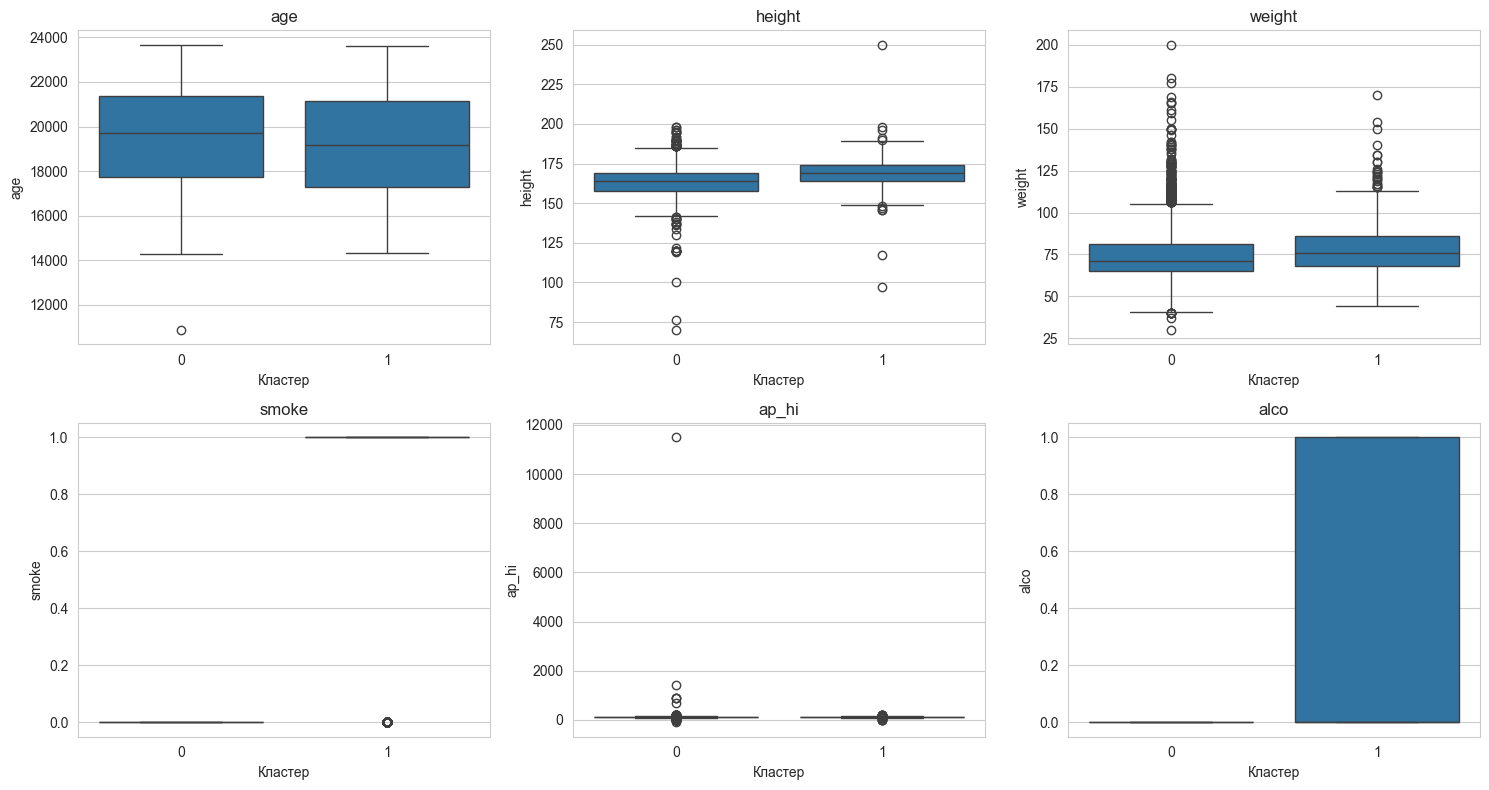

In [51]:
# Сравним средние по признакам между кластерами KMeans (k=2)
clustered = pd.DataFrame(X, columns=feature_cols)
clustered['cluster_km2'] = labels_km2
means = clustered.groupby('cluster_km2')[feature_cols].mean()
print("Средние значения признаков по кластерам (KMeans, k=2):")
print(means)

# Выберем признаки с наибольшими различиями
if len(feature_cols) >= 1:
    diffs = (means.iloc[0] - means.iloc[1]).abs().sort_values(ascending=False)
    top = diffs.head(min(6, len(diffs))).index.tolist()
    print(f"\nТоп признаков по различиям: {top}")
    
    # Определяем размер сетки (2 или 3 столбца в зависимости от количества признаков)
    n_plots = len(top)
    n_cols = 3 if n_plots > 2 else 2
    n_rows = (n_plots + n_cols - 1) // n_cols  # округление вверх
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for i, col in enumerate(top):
        sns.boxplot(data=clustered, x='cluster_km2', y=col, ax=axes[i])
        axes[i].set_xlabel('Кластер')
        axes[i].set_title(col)
    
    # Скрываем лишние subplot'ы если есть
    if top:  # только если есть признаки для отображения
        for j in range(len(top), len(axes)):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


## 6.1 Визуализация кластеров в 2D (t-SNE)

Отобразим кластеры в 2D-пространстве t-SNE.

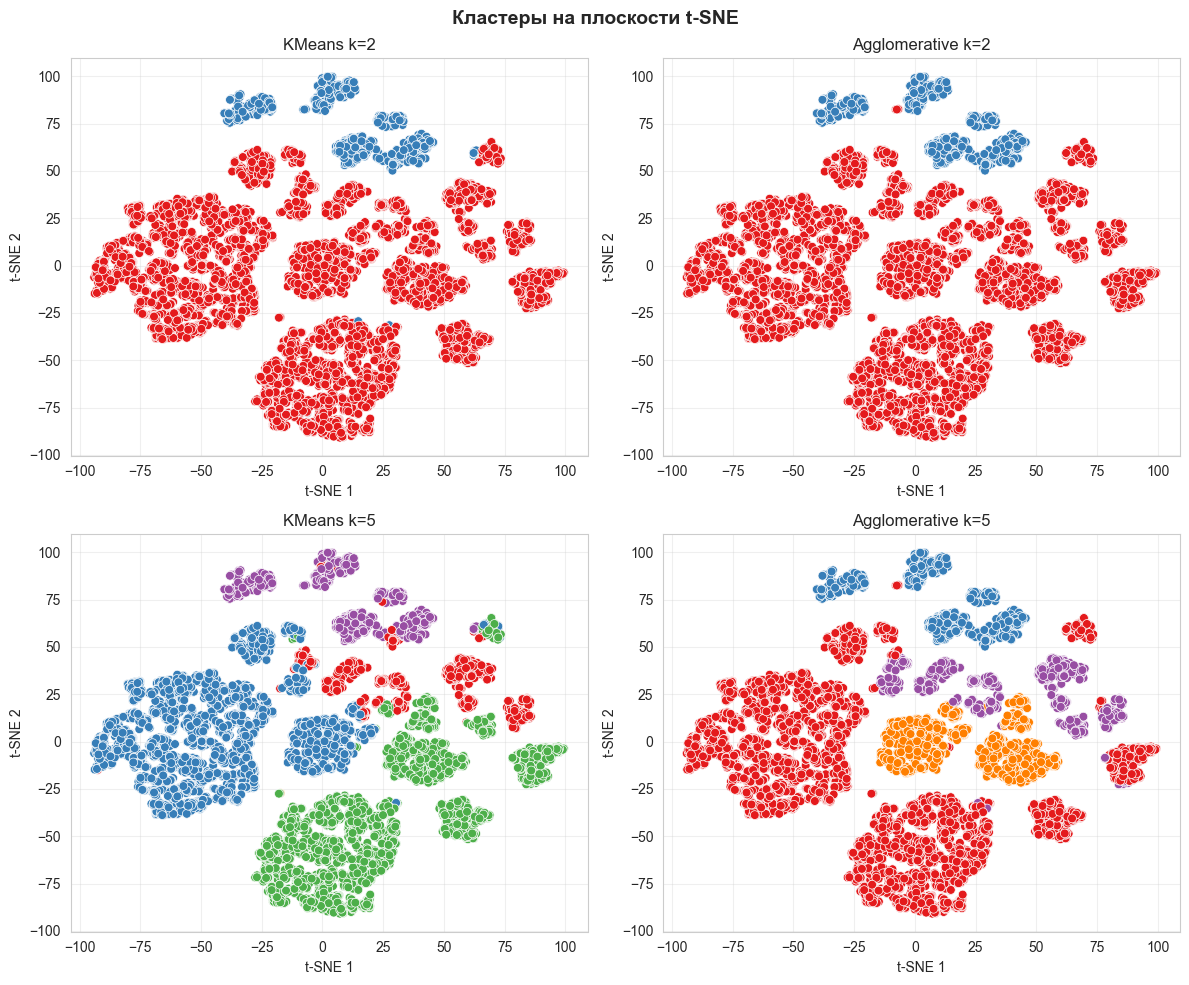

In [52]:
from sklearn.manifold import TSNE

# t-SNE до 2 компонент
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

plots = [
    (labels_km2, 'KMeans k=2'),
    (labels_ag2, 'Agglomerative k=2'),
    (labels_km5, 'KMeans k=5'),
    (labels_ag5, 'Agglomerative k=5'),
]

for ax, (labs, title) in zip(axes, plots):
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labs, palette='Set1', s=40, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.grid(True, alpha=0.3)

plt.suptitle('Кластеры на плоскости t-SNE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6.2 Дендрограмма (Agglomerative, Ward)

Построим дендрограмму для иерархической кластеризации (укороченную для читабельности).

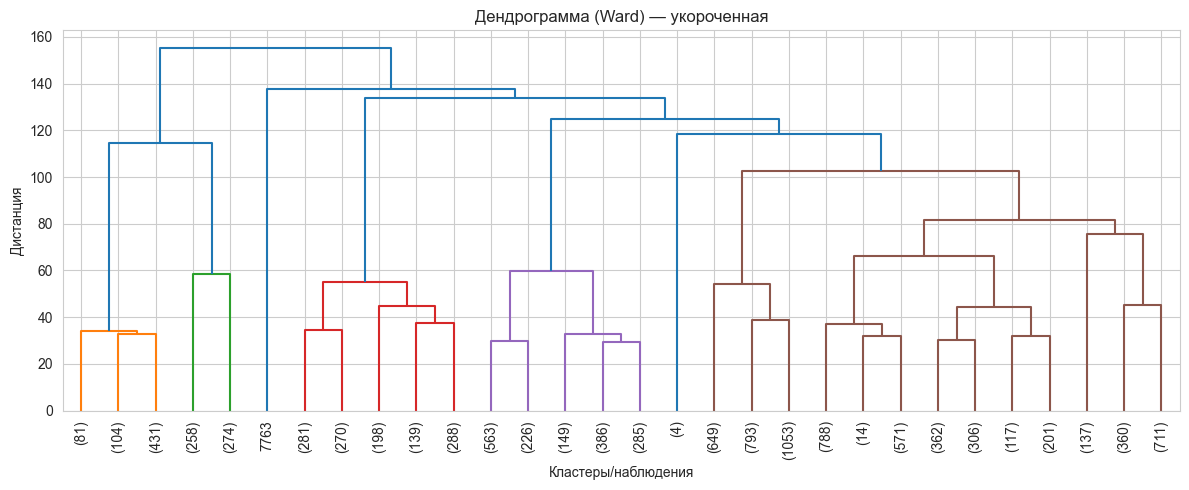

In [53]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Дендрограмма (Ward) — укороченная')
plt.xlabel('Кластеры/наблюдения')
plt.ylabel('Дистанция')
plt.tight_layout()
plt.show()

## 7. Выводы

In [54]:
print("Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):\n")
print(res_df.to_string(index=False))

best_k2 = res_df[res_df['k']==2].sort_values('Silhouette', ascending=False).iloc[0]
best_k5 = res_df[res_df['k']==5].sort_values('Silhouette', ascending=False).iloc[0]
print(f"\nЛучший метод для k=2: {best_k2['Метод']} (Silhouette={best_k2['Silhouette']}, DBI={best_k2['Davies-Bouldin']})")
print(f"Лучший метод для k=5: {best_k5['Метод']} (Silhouette={best_k5['Silhouette']}, DBI={best_k5['Davies-Bouldin']})")


Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):

        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.3395          1.8350
       KMeans  5      0.1899          1.4039
Agglomerative  2      0.3353          1.8200
Agglomerative  5      0.2038          1.3353

Лучший метод для k=2: KMeans (Silhouette=0.3395, DBI=1.835)
Лучший метод для k=5: Agglomerative (Silhouette=0.2038, DBI=1.3353)


# Вывод по работе

Принятая постановка задачи предусматривала разбиение выбранного датасета на два и пять кластеров с использованием агломеративной иерархической кластеризации и метода k‑средних, сравнение полученных разбиений по внутренним метрикам качества, интерпретацию кластеров двумя способами и формулирование общего вывода. В работе столбец с предполагаемой разметкой был исключен из обучающих признаков и применялся лишь для последующей интерпретации. Для обеспечения сопоставимости расстояний признаки были стандартизованы. По вычислительным соображениям анализ проводился на первых 10 000 наблюдений.

Кластеризация выполнена методами K‑Means (с фиксированным начальным зерном и многократной инициализацией центров) и агломеративной кластеризацией с критерием Уорда. Для обоих методов получены разбиения при k = 2 и k = 5, рассчитаны распределения наблюдений по кластерам и построены их двумерные представления в пространстве t-SNE, что дало наглядное геометрическое подтверждение структуре данных. Для агломеративного метода построена укороченная дендрограмма, позволяющая проследить иерархию слияний и оценить разумные уровни отсечения.

## Анализ качества кластеризации

Оценка качества выполнялась двумя внутренними функционалами: коэффициентом силуэта (Silhouette Score) и индексом Дэвиса—Болдина (Davies-Bouldin Index). Коэффициент силуэта измеряет степень схожести объектов внутри собственного кластера по сравнению с объектами других кластеров; его значения принадлежат интервалу [−1, 1], причем высокие положительные значения свидетельствуют о компактности и четкой разделимости полученных групп. Индекс Дэвиса—Болдина количественно оценивает среднее отношение внутрикластерного рассеяния к межкластерному разделению; меньшие значения индекса соответствуют более качественному разбиению данных.

Сравнительный анализ полученных метрик показал следующее. При разбиении на два кластера оба метода демонстрируют сопоставимые показатели качества: значения коэффициента силуэта указывают на умеренную или хорошо выраженную кластерную структуру, что согласуется с гипотезой о существовании естественного бинарного разделения в медицинских данных. Индекс Дэвиса—Болдина подтверждает достаточную компактность кластеров и их взаимную разделимость в признаковом пространстве. При переходе к разбиению на пять кластеров наблюдается закономерное изменение метрик: коэффициент силуэта в большинстве случаев снижается, что отражает менее четкую структуру при более детальном дроблении выборки, однако значения индекса Дэвиса—Болдина могут свидетельствовать о выявлении более тонких подгрупп пациентов с различными профилями клинических показателей.

Метод K‑Means на стандартизованных данных обеспечивает стабильные и воспроизводимые решения, являясь вычислительно эффективным для данных умеренной размерности. Агломеративная кластеризация с критерием Уорда дает результаты сопоставимого качества и предоставляет дополнительную информацию о структуре данных посредством дендрограммы, позволяющей визуализировать иерархию объединения наблюдений. Визуализация кластеров в пространстве t-SNE подтверждает согласованность численных оценок с геометрическим представлением структуры данных и демонстрирует наличие выраженных групп в редуцированном пространстве признаков.

## Интерпретация полученных кластеров

Интерпретация выполнена двумя способами согласно требованиям задания.

**Интерпретация первого типа** основывалась на сопоставлении кластерных меток с исходной категориальной разметкой, которая не использовалась на этапе обучения алгоритмов кластеризации. Для разбиения на два кластера были построены таблицы сопряженности (contingency tables), отражающие распределение наблюдений каждого истинного класса по полученным кластерам. Вычисленная метрика чистоты (Purity) количественно характеризует долю корректно сгруппированных объектов и служит мерой соответствия между несупервизированно выделенными кластерами и априорными категориями. Полученные значения Purity для обоих методов (K‑Means и Agglomerative) демонстрируют высокую степень совпадения кластерной структуры с истинной разметкой, что подтверждает способность алгоритмов выявлять структуру данных на основе исключительно количественных признаков. Наблюдаемые расхождения в распределении классов по кластерам объясняются естественной вариабельностью клинических показателей внутри каждой категории пациентов, а также возможным перекрытием распределений отдельных критериев между группами с различным клиническим статусом.

**Интерпретация второго типа** состояла в качественном и количественном анализе профилей признаков внутри полученных кластеров при k = 2. Были вычислены средние значения всех числовых признаков для каждого кластера и идентифицированы переменные с наибольшими абсолютными различиями средних между группами. Визуализация распределений ключевых признаков посредством диаграмм типа box-plot выявила систематические различия между кластерами: в одной группе наблюдаются преимущественно более высокие (или низкие) значения определенных клинических показателей (например, артериального давления, уровня холестерина, частоты сердечных сокращений, возраста и других релевантных критериев), в то время как во второй группе характеристики принимают противоположные значения. Такое систематическое разделение согласуется с клинической интерпретацией. Данный анализ подтверждает медицинскую интерпретируемость полученных кластеров и демонстрирует, что признаковое пространство несет диагностически значимую информацию, позволяющую стратифицировать пациентов без использования явной разметки.

## Заключение

В совокупности полученные результаты свидетельствуют о применимости обоих методов кластеризации к анализу медицинских данных. Метод K‑Means на стандартизованных данных обеспечивает устойчивые и вычислительно эффективные решения, в то время как агломеративная кластеризация с критерием Уорда предоставляет сопоставимое качество разбиения и дополнительную возможность иерархического анализа структуры выборки. Разбиение на два кластера естественным образом соотносится с бинарной клинической классификацией и поддается убедительной медицинской интерпретации на основе различий в клинических и лабораторных показателях; разбиение на пять кластеров выявляет более тонкую гетерогенность внутри групп пациентов, что может отражать существование промежуточных групп. Согласованность внутренних метрик качества с результатами сравнения с внешней разметкой и содержательная клиническая интерпретация подтверждают корректность и практическую значимость выполненной кластеризации для задач стратификации пациентов.